---
title: Test
author: vanh
date: 'July, 13,2023'
format:
    html:
        code-fold: false
execute:
    enabled: true
---

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import grad
torch.set_grad_enabled(True)


## General Sigmoid

The sigmoid work well with linear monotonic relationship which have area of increase, decrease and flat.

This new sigmoid function is more flexible because it allows us to pass an entire data matrix X with m rows and n columns, and a set of n + 1 parameters $(\beta_{i:n+1})$ and will return the result of the sigmoid applied to each of the m  rows in X . 

Note that in the above implementation $\beta_0 $ is assumed to be the intercept term in the linear equation.

$$\color{orange}{ \hat{y} = w_0 + w_1\sigma_1(x) + w_2\sigma_2(x)}$$

where w is weight must be between 0 and 1 so it's need a constrain function e.g. another sigmoid and 
x is input value. Stacking sigmoid 2 or more sigmoid together.

$$\color{orange}{ \hat{y} = \sigma(w_0 + w_1\sigma_1(x) + w_2\sigma_2(x))}$$

In [3]:


#------------------------------------------------------
# A more general purpose signmoid
#------------------------------------------------------
def sigmoid(beta, X):
    lin = np.dot(X, beta[1:]) + beta[0]
    return 1/(1 + np.exp(-(lin)))



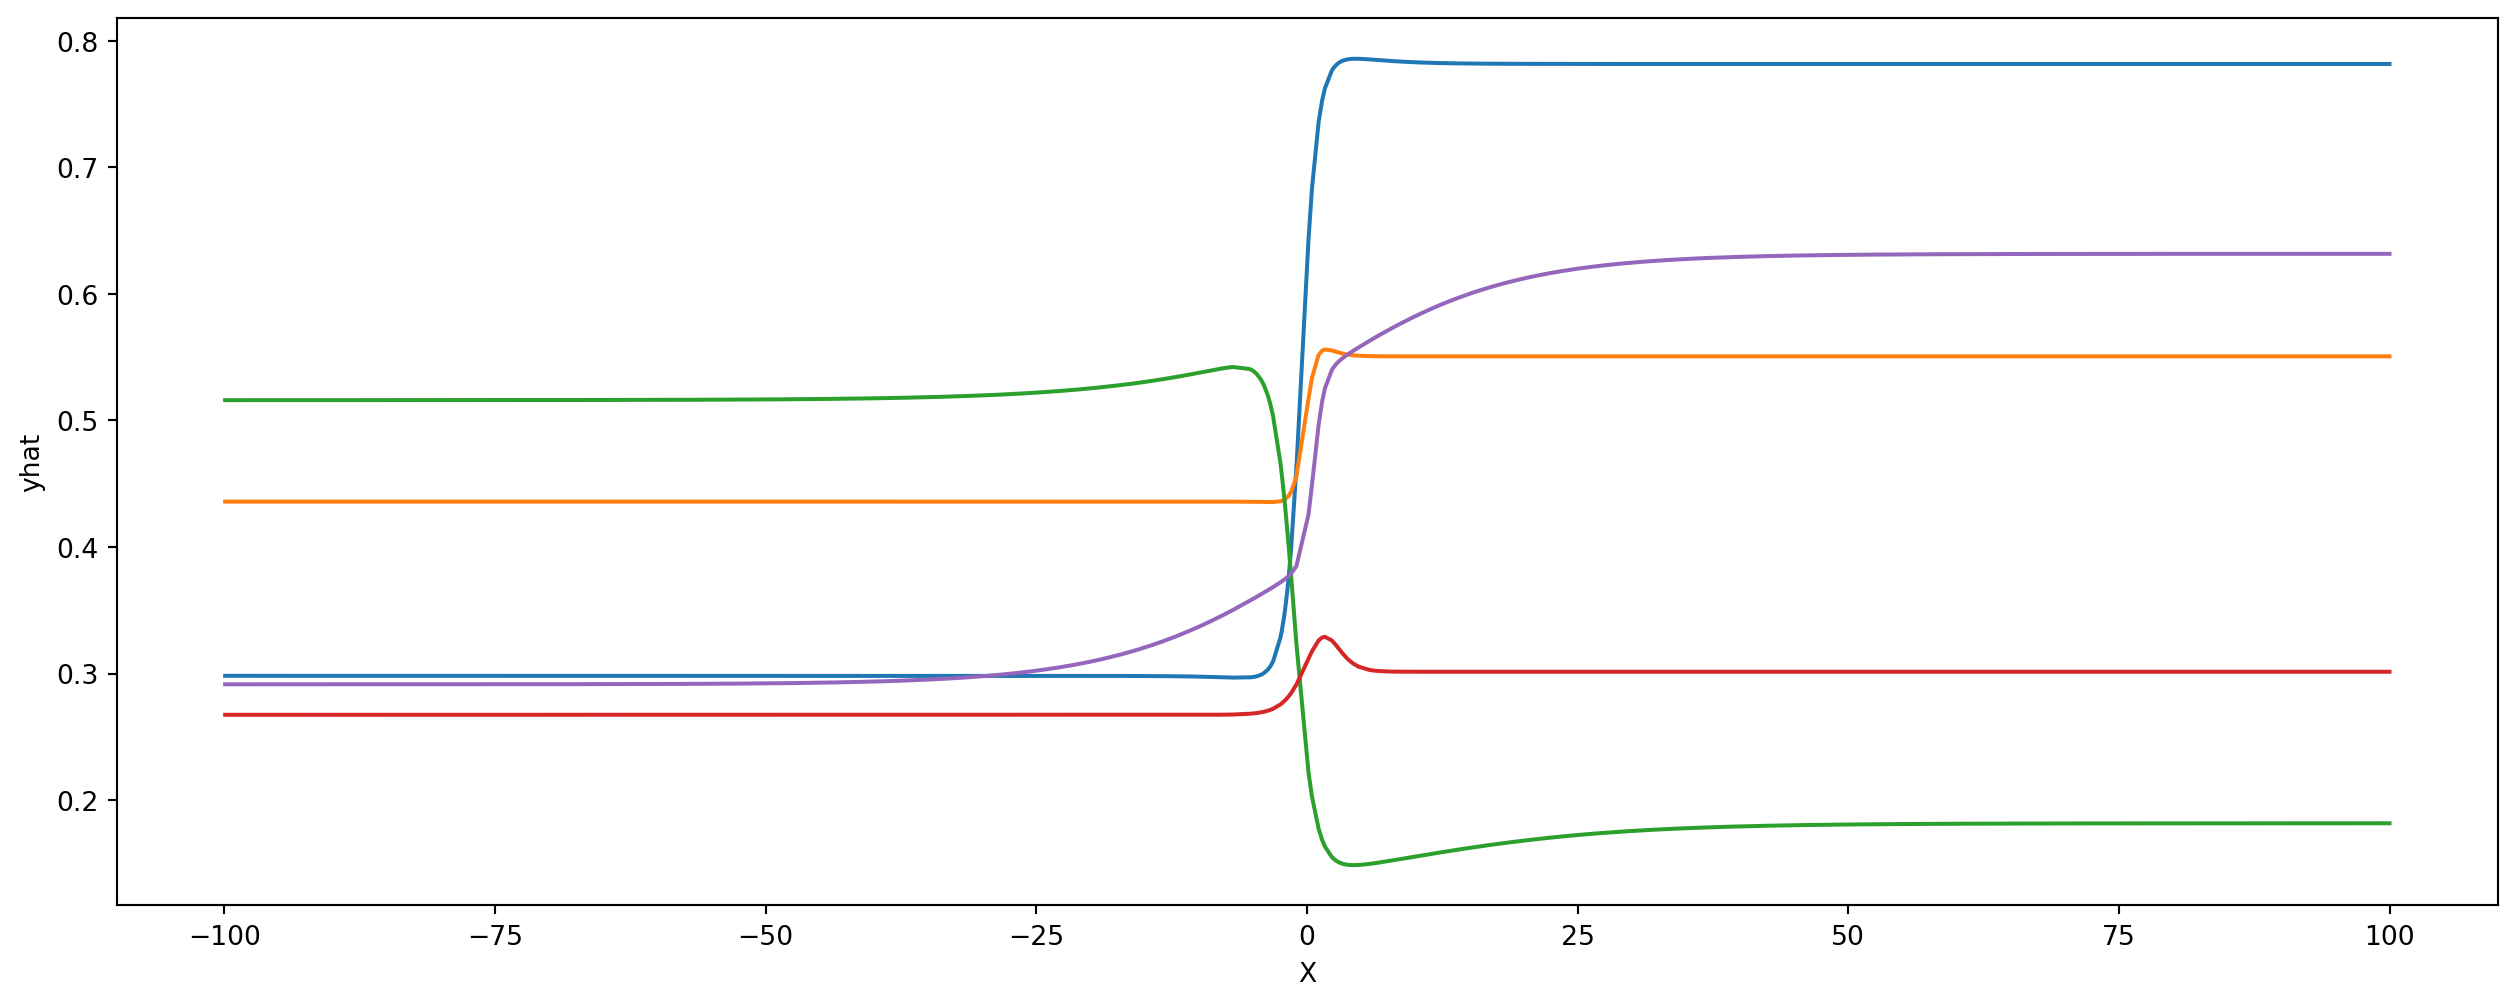

In [4]:
#| label: sigmoid_plot

plt.figure(figsize = (16,6))

# Initialize some random value for some data X and parameters beta
X  = np.random.uniform(low= -100, high = 100, size = (1000,1))

# For 5 random models
for x in range(5):
    # For some random values of betas
    beta1  = np.random.normal(size = (np.shape(X)[1] + 1,1))
    beta2  = np.random.normal(size = (np.shape(X)[1] + 1,1))

    # Pack the sigmoids into a new `X` 
    X2  = np.concatenate((sigmoid(beta1 ,X),sigmoid(beta2 ,X)),axis=1)
      
    # For some random values of w, create yhat.
    num_ws = np.shape(X2)[1] + 1
    ws     = np.random.normal(size = (np.shape(X2)[1] + 1,1))
    yhat   = sigmoid(ws ,X2) 
    
    # Print it
    index  = np.argsort(X[:,0])
    X      = X[index,:]; 
    yhat   = yhat[index,:]
    plt.plot(X,yhat)
    plt.xlabel('X');plt.ylabel('yhat')
plt.show()



## Neural Network using PyTorch

The technique of stacking more sigmoid together into a layer to increase flexibility is called Neural network.
The most popular library for NN is called PyTorch

In [5]:
# import torch

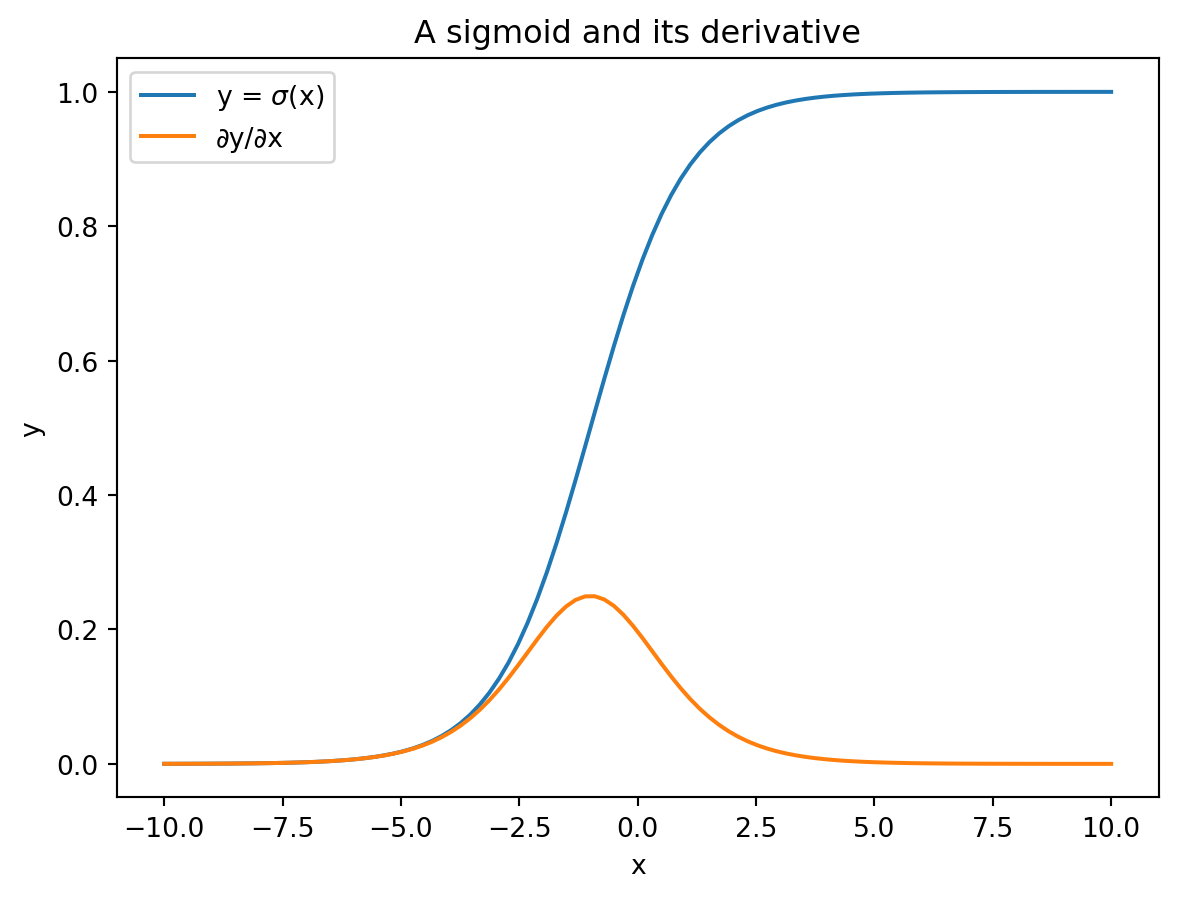

In [6]:

grad, xnp, ynp = [], [],[]

#------------------------------------------------
# Initialize some parameters of a model
#------------------------------------------------
b1 =  torch.tensor(1.0, requires_grad=True)
m1 =  torch.tensor(1.0, requires_grad=True)

#------------------------------------------------
# For some various values of x
#------------------------------------------------
X = np.linspace(-10,10,100)
for x in X:
    #------------------------------------------------
    # Convert x into a torch tensor
    #------------------------------------------------
    x =  torch.tensor(x, requires_grad=True)

    #------------------------------------------------
    # compute y using x and the parameters m1,m2,b1,b2
    #------------------------------------------------
    y =  1 / (1 + torch.exp(-(m1*x+b1)))
    
    #------------------------------------------------
    # calculate the gradient in y with respect to x
    # using the back-propagation algorithm
    #------------------------------------------------
    y.backward()  # ∂y/∂x = 2   

    #------------------------------------------------
    # Store the gradients
    #------------------------------------------------    
    grad.append( x.grad.numpy() )
    xnp.append( x.detach().numpy() )
    ynp.append( y.detach().numpy() )
    

#------------------------------------------------
# Plot the results
#------------------------------------------------   
plt.plot(xnp , ynp , label='y = $\sigma$(x)')
plt.plot(xnp ,grad, label='∂y/∂x')
plt.title('A sigmoid and its derivative')   
plt.xlabel('x'), plt.ylabel('y')
plt.legend()
plt.show()



In [7]:


# import torch
# import torch.nn as nn
# import torch.optim as optim
# import torch.nn.functional as F
# from torch.autograd import grad
# torch.set_grad_enabled(True)



### Logistic regression using Pytorch model

In [8]:
#------------------------------------------------
# Define a Model
#------------------------------------------------
class LogisticRegression(nn.Module): 
    
    #------------------------------------------------
    # Torch Requires an init function where the
    # parameters of the model are specified
    #------------------------------------------------
    def __init__(self, n_inputs, n_outputs):
        
        # This line calls the init function of "nn.Module"; 
        # you must always do this in any "nn.Module"
        super(LogisticRegression, self).__init__()
        
        # Indicates that our model parameters are a 
        # linear function that maps n inputs to n_outputs
        self.linear  = nn.Linear(n_inputs, n_outputs)
        
    #------------------------------------------------
    # Torch also Requires an forward function that specifies 
    # what to do with the output (e.g. apply a sigmoid).
    #------------------------------------------------
    def forward(self, x):
        
        # Indicates that we must pass the linear component of the 
        # model (mx + b ) through a sigmoid before returning the results
        return torch.sigmoid( self.linear(x) )


In [9]:

#------------------------------------------------
# Define Training Function
#------------------------------------------------  
def train_model(model, x, y, hyperparams):

    loss_function = hyperparams['loss_function']
    optimizer     = torch.optim.SGD(model.parameters(), hyperparams['learning_rate']) 
    model.train()
        
    # Iterate over our data as many times as there are `epochs`
    losses = []
    for e in range(hyperparams['epochs']):
        
        #Clear out the gradients from the last `epoch`:
        model.zero_grad()

        # Compute the output of the model, yhat, given x
        yhat = model(x)

        # Compute the loss
        loss = loss_function(yhat, y)
        
        # Compute the gradient in the loss with respect to the parameters
        loss.backward()

        # Adjust the parameter values in the direction of the gradients
        optimizer.step()

        # Save the loss at each iteration for plotting
        losses.append(loss.detach().numpy())
    
    return model, losses

#------------------------------------------------
# Define Evaluation Function
#------------------------------------------------  
def eval_model(model, x, y, hyperparams):
    model.eval()
    yhat     = model(x)
    
    # calculating accuracy
    equals       = torch.round(yhat.squeeze(1)) == y.squeeze(1)
    count_equals = torch.sum(equals).numpy()
    num_examples = y.shape[0]
    accuracy     = count_equals / num_examples
    return accuracy



In [10]:

#------------------------------------------------------
# Open the Data File
#------------------------------------------------------
import json


with open('../../data/json_file/dummydata.json') as f:
    data = json.load(f)
    
    
#------------------------------------------------
# Convert our dummy data to torch format
#------------------------------------------------
x = torch.tensor(data['x']) 
x = x.to(torch.float)
x = x.view(np.shape(data['x'])[0], 1)

y = torch.tensor(data['y'])
y = y.to(torch.float)
y = y.view(np.shape(data['y'])[0] , 1)



In [11]:

#------------------------------------------------
# Define model hyperparamters 
#------------------------------------------------
hyperparams = {}
hyperparams['input_dim']      = 1             # Number of columns in the input data 'x'
hyperparams['output_dim']     = 1             # Number of targets you want to predict 'y'
hyperparams['random_seed']    = 4             # Random seed - this will impact initial weights.
hyperparams['loss_function']  = nn.BCELoss()  # loss function  (Binary Cross Entropy Loss = BCELoss )
hyperparams['learning_rate']  = 0.01          # learning rate for the optimizer
hyperparams['epochs']         = 100000        # number of runs over the training data



Text(0.5, 1.0, 'Logistic Regression with final accuracy: 96.09%')

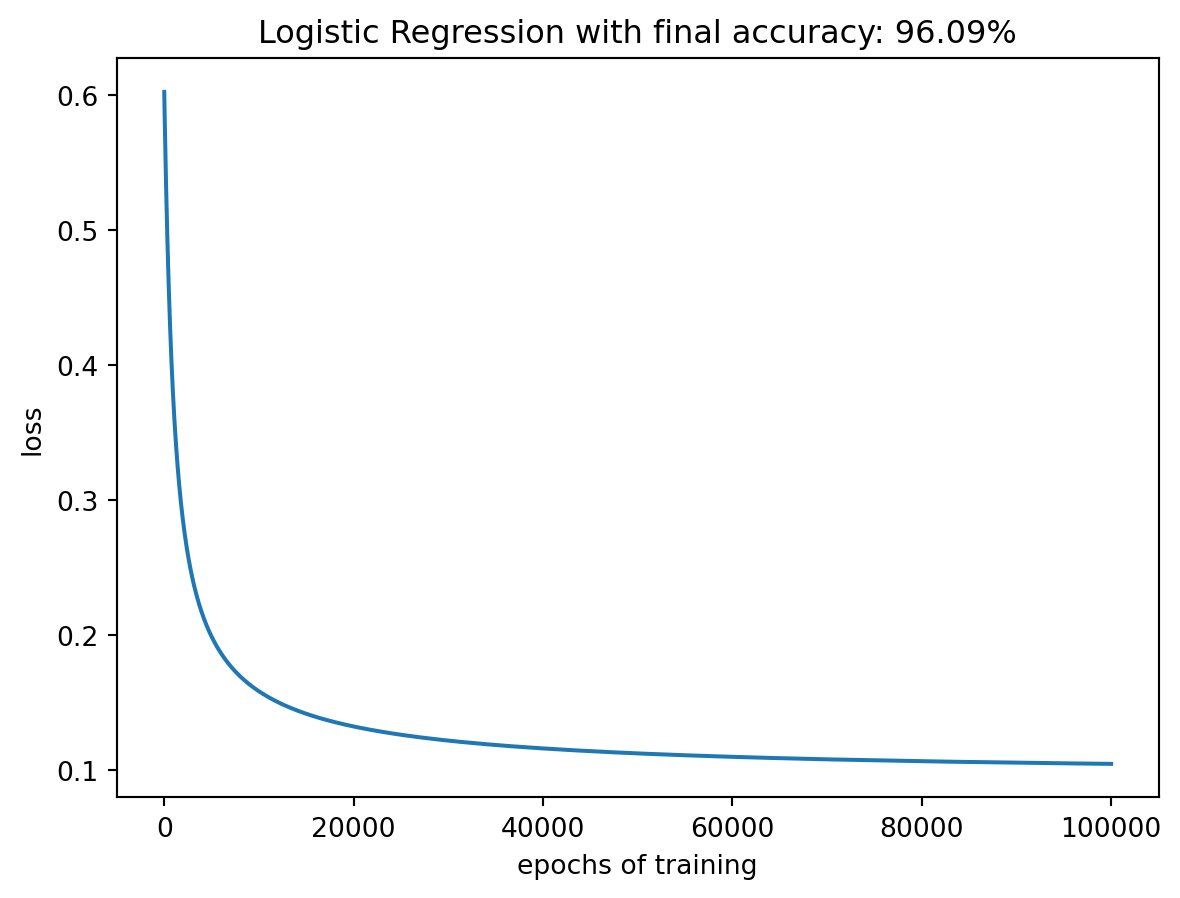

In [12]:
#------------------------------------------------
# Initiate, Train and Evaluate our model
#------------------------------------------------
torch.manual_seed(hyperparams['random_seed'])

model            = LogisticRegression(hyperparams['input_dim'], hyperparams['output_dim'])
model, losses    = train_model( model, x, y, hyperparams)
accuracy         = eval_model(  model, x, y, hyperparams)

#------------------------------------------------
# Plot the performance
#------------------------------------------------
plt.plot(losses)
plt.xlabel('epochs of training')
plt.ylabel('loss')
plt.title('Logistic Regression with final accuracy: ' + str(100*accuracy)[0:5] + '%')

most of the gains occur after the first 10,000 or so epochs and then the loss improves only slightly thereafter.
Do sanity check these results by looking at the paramter values to make sure they are close to the values of -12,1.7

In [13]:
#------------------------------------------------
# Print the Paramters
#------------------------------------------------
print('----------------------------')
print('Model Parameters:')
print('----------------------------')
for param in model.parameters():    
    print(param.detach().squeeze().numpy())

----------------------------
Model Parameters:
----------------------------
1.5126332
-11.088784



## Feed Forward Neural Networks

Now let's try training a multi-layer neural network, also known as a feed-forward network. neural networks are flexible function approximators as long as we add enough nodes and layers should be able to fit data well using a neural network


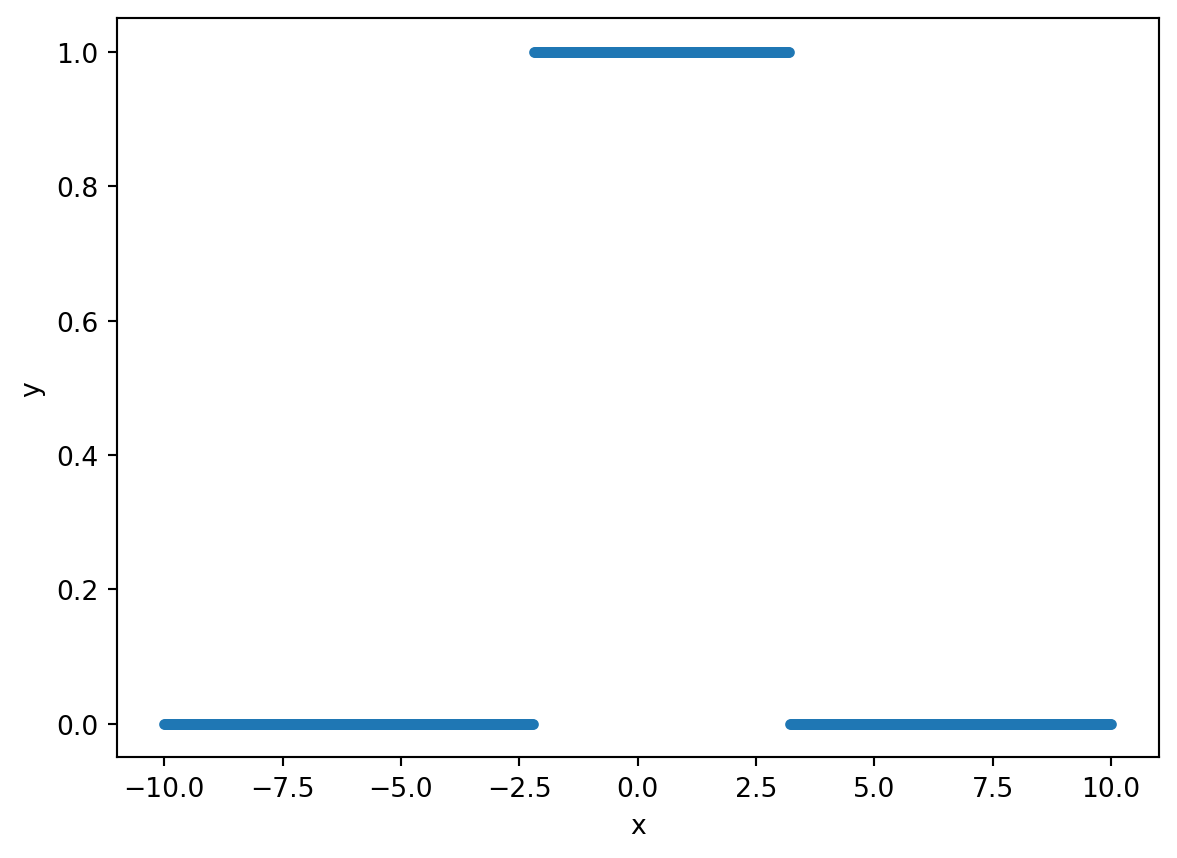

In [14]:

#------------------------------------------------
# Creating a Dummy Dataset For Neural Network Training
#------------------------------------------------
x = np.linspace(-10,10,1000) 
y = 1- np.round(1/ (1+ np.exp(-x * x + 2 + x + 5 + np.random.normal())))
plt.plot(x,y,'.'); plt.xlabel('x'); plt.ylabel('y'); plt.show()



In [15]:

#------------------------------------------------
# Convert our data to torch format
#------------------------------------------------
x = torch.tensor(x) 
x = x.to(torch.float)
x = x.view(np.shape(x)[0], 1)

y = torch.tensor(y)
y = y.to(torch.float)
y = y.view(np.shape(y)[0] , 1)



define a new model called ShallowNet that consists of 4 layers: 1 input, 2 middle layers (also known as hidden layers) and an output layer

In [16]:


#------------------------------------------------
# Define a Model
#------------------------------------------------
class ShallowNet(nn.Module):
    def __init__(self, input_dim, hidden_size, output_dim):  
        # Inherited from the parent class nn.Module
        super(ShallowNet, self).__init__()                       
        self.sigmoid = nn.Sigmoid()                         # sigmoid activation
        self.fc1     = nn.Linear(input_dim, hidden_size)    # 1st Full-Connected Layer: 1 (input data) -> # (hidden_size)
        self.fcm     = nn.Linear(hidden_size, hidden_size)  # 2nd Full-Connected Layer: 2 (hidden_size) -> # (hidden node)
        self.fcm2    = nn.Linear(hidden_size, hidden_size)  # 3rd Full-Connected Layer: 3 (hidden_size) -> # (hidden node)
        self.fc2     = nn.Linear(hidden_size, output_dim)   # 4rd Full-Connected Layer: 4 (hidden node) -> 1 (output class)
    
    # Forward pass: stacking each layer together
    def forward(self, x):                              
        out = self.fc1(x)
        out = self.sigmoid(out)
        out = self.fcm(out)
        out = self.sigmoid(out)
        out = self.fcm2(out)
        out = self.sigmoid(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out



In [17]:


#------------------------------------------------
# Define model hyperparamters 
#------------------------------------------------
hyperparams = {}
hyperparams['input_dim']      = 1             # Number of columns in the input data 'x'
hyperparams['output_dim']     = 1             # Number of targets you want to predict 'y'
hyperparams['random_seed']    = 5           # Random seed - this will impact initial weights.
hyperparams['loss_function']  = nn.BCELoss()  # loss function  (Binary Cross Entropy Loss = BCELoss )
hyperparams['learning_rate']  = 0.1          # learning rate for the optimizer
hyperparams['epochs']         = 15000         # number of runs over the training data

#------------------------------------------------
# Train a Logistic Regression
#------------------------------------------------
torch.manual_seed(hyperparams['random_seed'])
model            = LogisticRegression(hyperparams['input_dim'], hyperparams['output_dim'])
model, losses    = train_model( model, x, y, hyperparams)
accuracy1        = eval_model(  model, x, y, hyperparams)

#------------------------------------------------
# Train a Shallownet
#------------------------------------------------
torch.manual_seed(hyperparams['random_seed'])
model            = ShallowNet(hyperparams['input_dim'], 2, hyperparams['output_dim'])
model, losses2   = train_model( model, x, y, hyperparams)
accuracy2        = eval_model(  model, x, y, hyperparams)



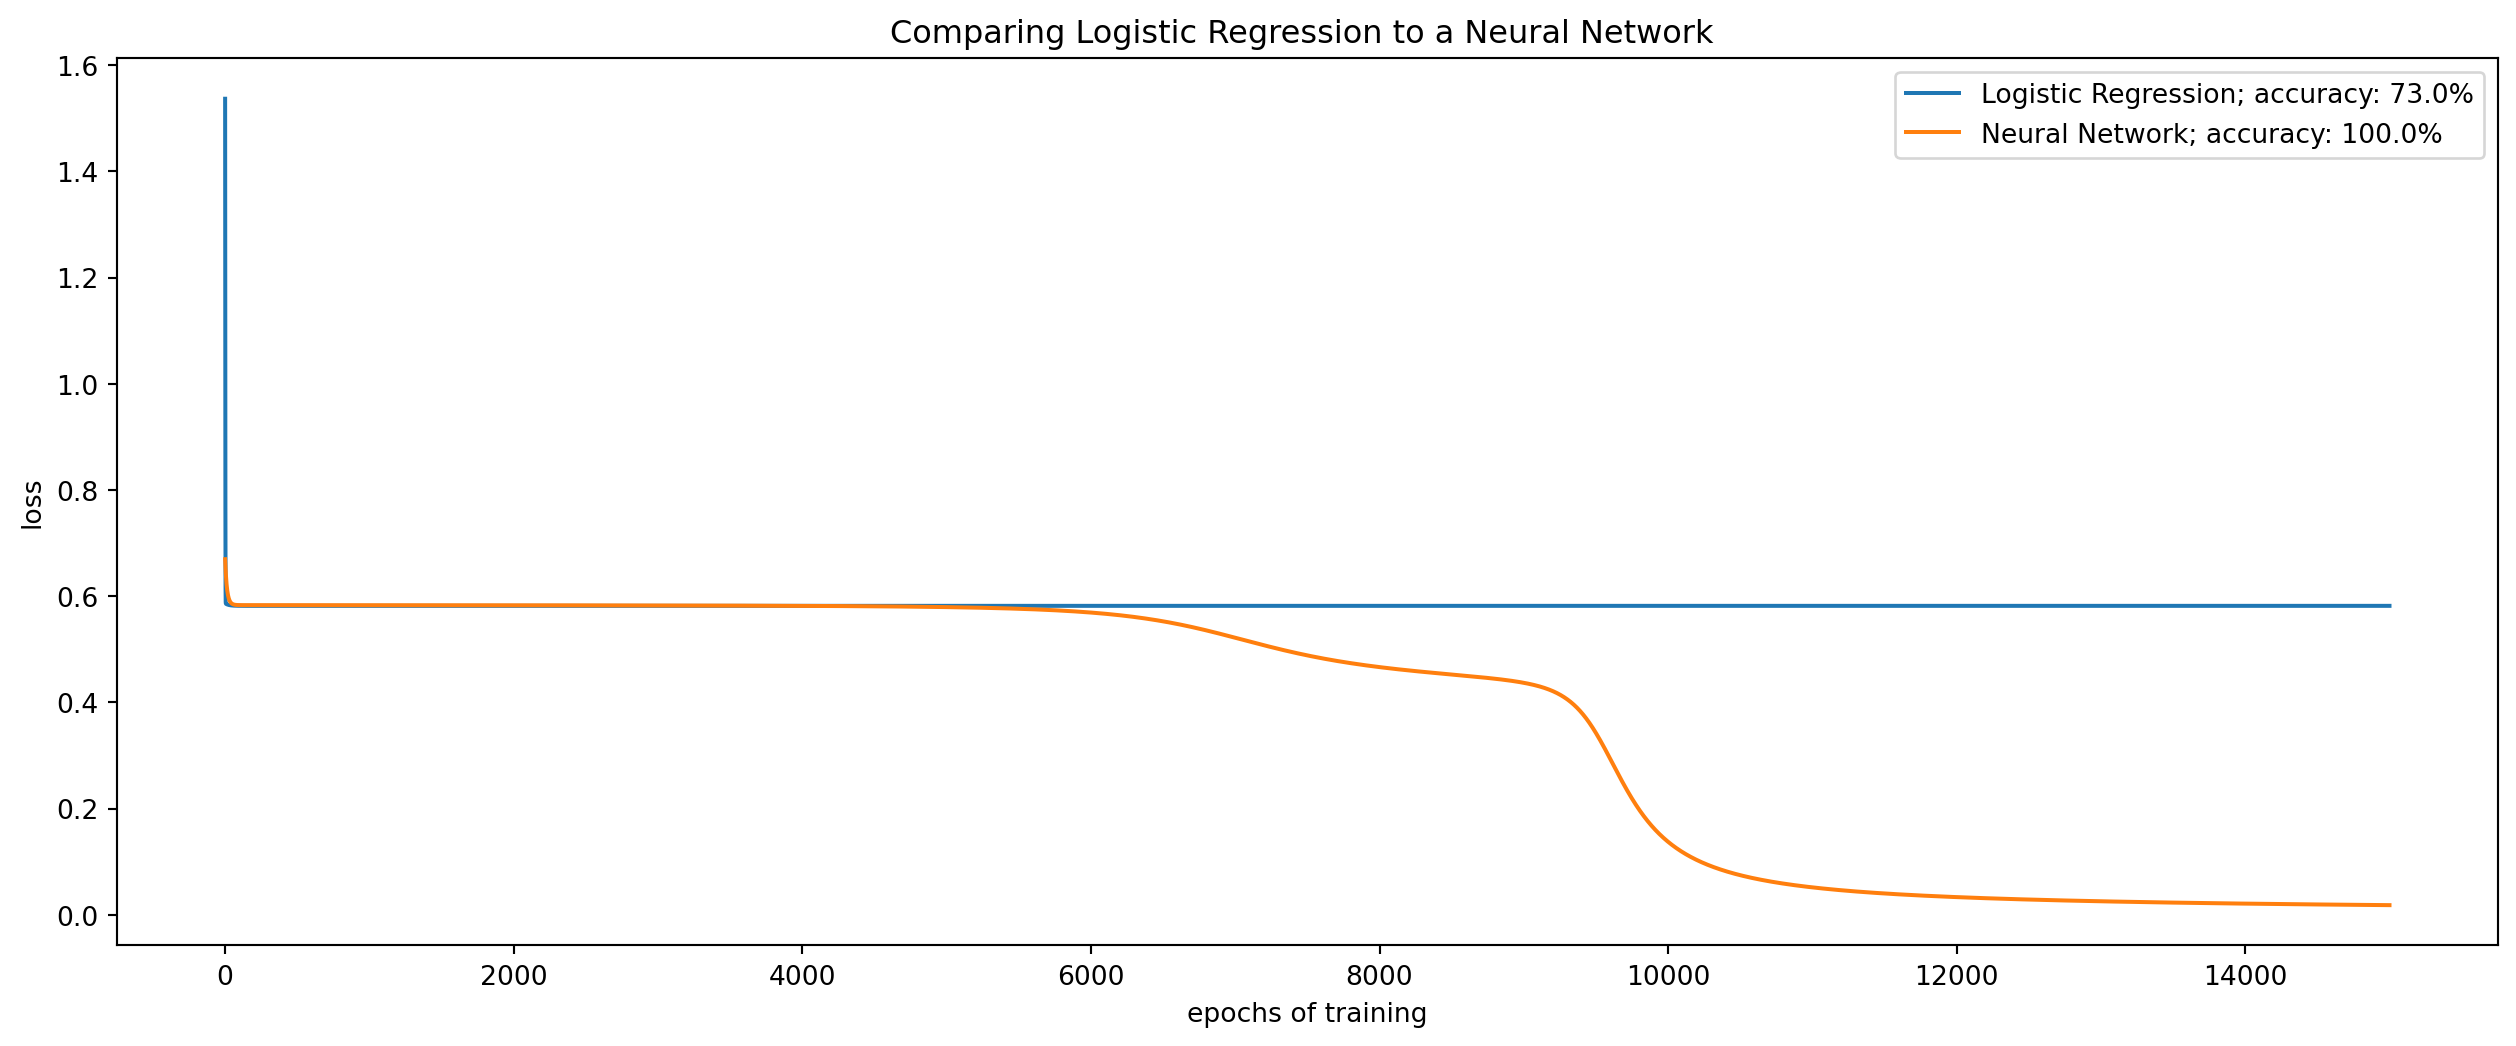

In [18]:


plt.figure(figsize = (16,6))
#------------------------------------------------
# Plot the performance
#------------------------------------------------
plt.plot(losses,  label='Logistic Regression; accuracy: ' + str(accuracy1 * 100)[0:5] + '%')
plt.plot(losses2, label='Neural Network; accuracy: ' + str(accuracy2 * 100) + '%')
plt.xlabel('epochs of training'); plt.ylabel('loss')
plt.title('Comparing Logistic Regression to a Neural Network ')
plt.legend()
plt.show()



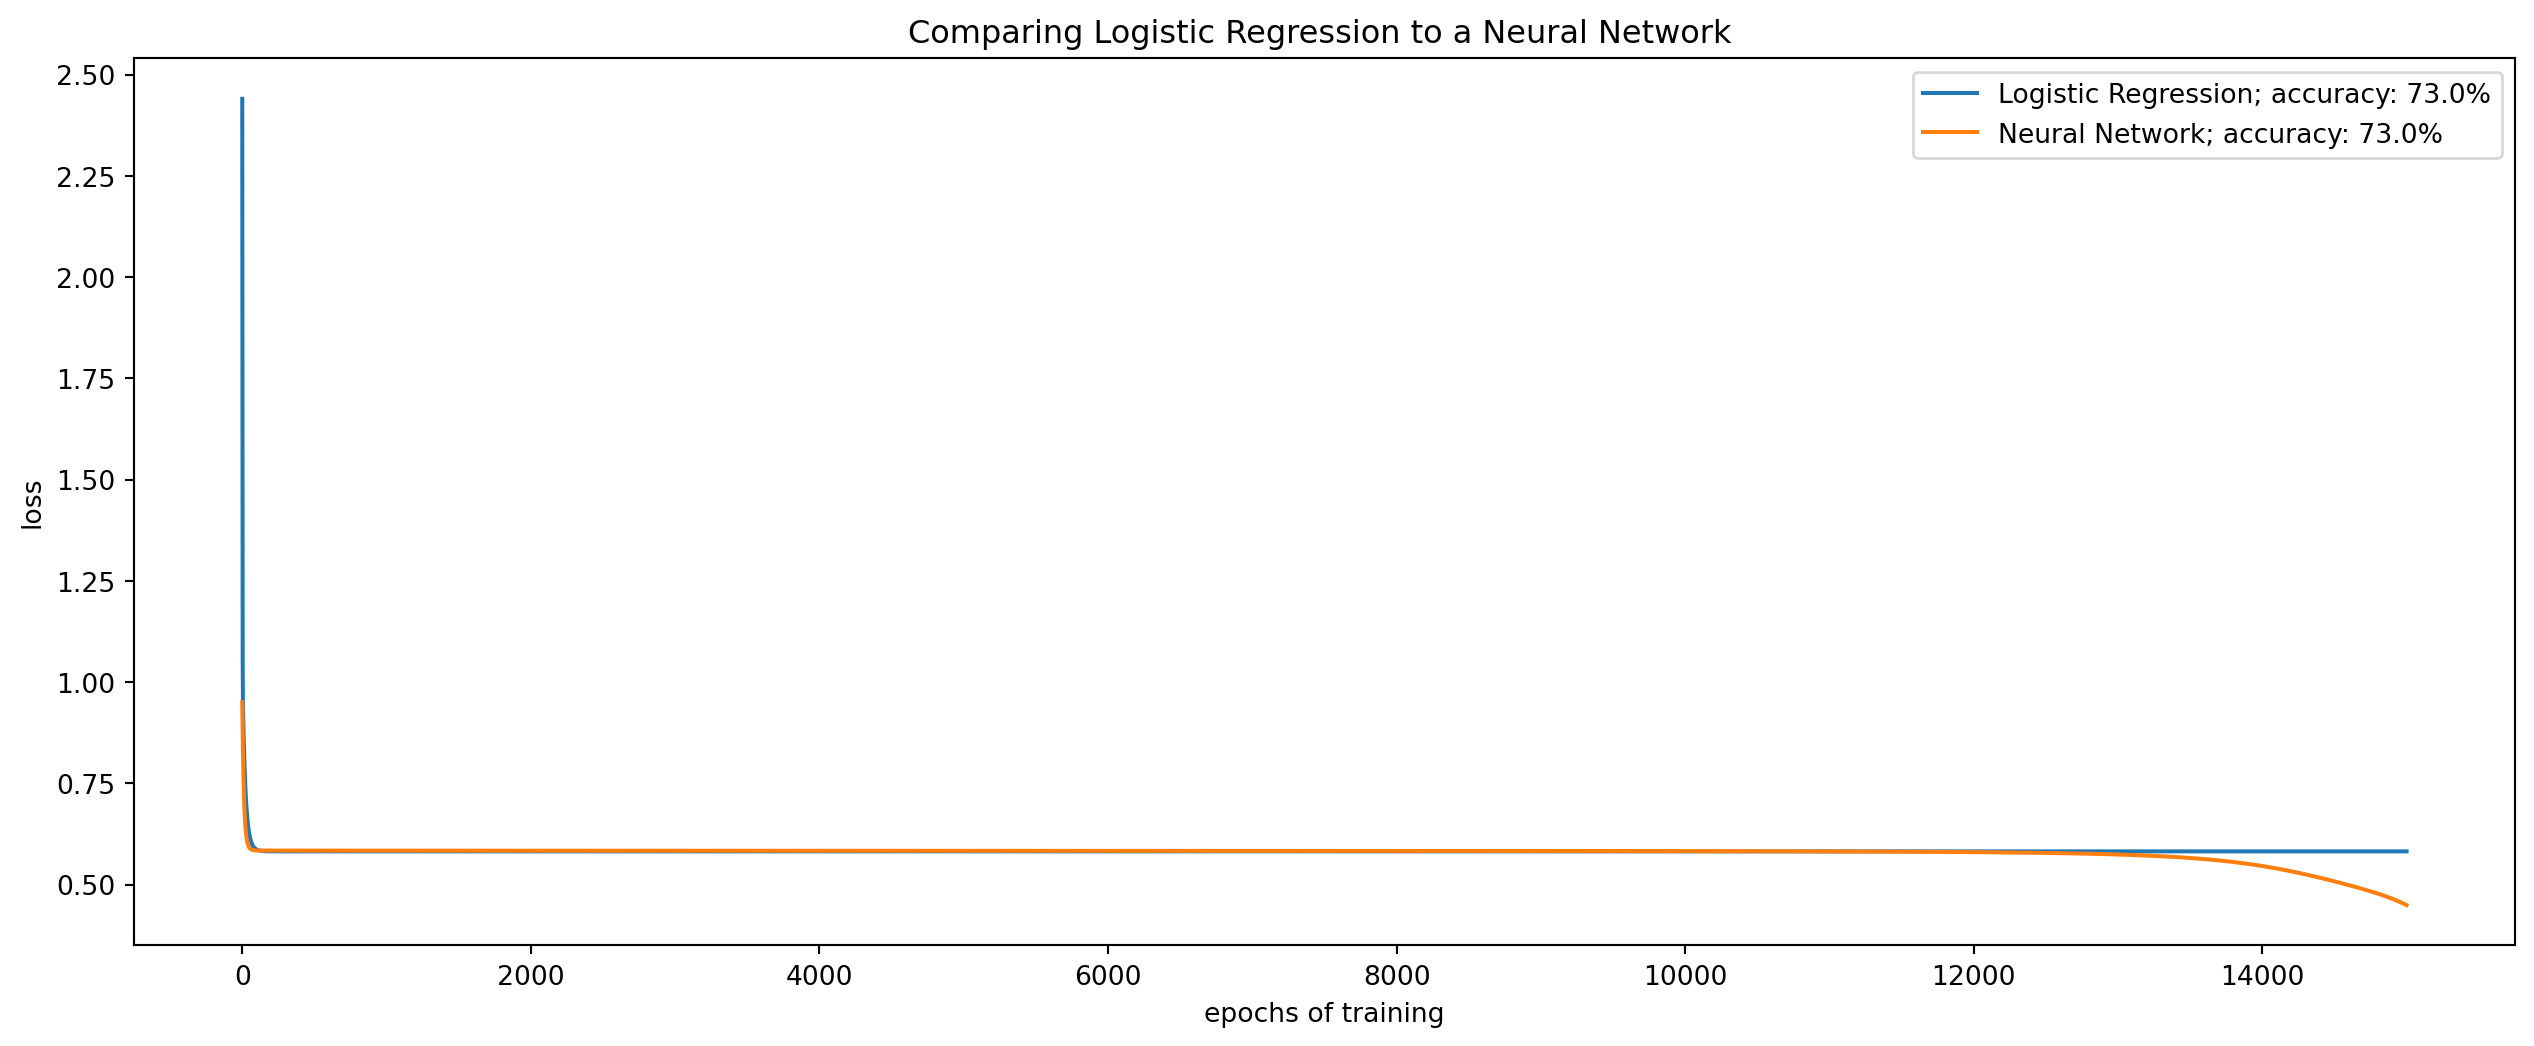

In [19]:
#------------------------------------------------
# Define model hyperparamters 
#------------------------------------------------
hyperparams['random_seed']    = 99             # Random seed - this will impact initial weights.

#------------------------------------------------
# Train a Logistic Regression
#------------------------------------------------
torch.manual_seed(hyperparams['random_seed'])
model            = LogisticRegression(hyperparams['input_dim'], hyperparams['output_dim'])
model, losses    = train_model( model, x, y, hyperparams)
accuracy1        = eval_model(  model, x, y, hyperparams)

#------------------------------------------------
# Train a Shallownet
#------------------------------------------------
torch.manual_seed(hyperparams['random_seed'])
model            = ShallowNet(hyperparams['input_dim'], 2, hyperparams['output_dim'])
model, losses2   = train_model( model, x, y, hyperparams)
accuracy2        = eval_model(  model, x, y, hyperparams)

plt.figure(figsize = (16,6))
#------------------------------------------------
# Plot the performance
#------------------------------------------------
plt.plot(losses,  label='Logistic Regression; accuracy: ' + str(accuracy1 * 100)[0:5] + '%')
plt.plot(losses2, label='Neural Network; accuracy: ' + str(accuracy2 * 100) + '%')
plt.xlabel('epochs of training'); plt.ylabel('loss')
plt.title('Comparing Logistic Regression to a Neural Network ')
plt.legend()
plt.show()


The only thing that was changed between this run, and the previous example was the seed of the random number generator, which controls (among other things) the initial point from which we will start our gradient descent!

This is critical for you to see because if your network's loss is not decreasing beyond that of a simple model (such as a logistic regression), 

it provides evidence of an unlucky starting position, or some other hyper-paramter issue. 

In practice, the way that you overcome this is by simply testing many settings of the hyper-parmaters

### Specify A Neural Classification Model

- Using Pytorch, specify a neural network model that will map a sparse bag-of-words representation of the Rotton Tomatoes Movie Review Dataset from part 1 of the tutorial to the probability of the movie review being positive. It's up to you to choose the number of layers and the number of nodes; just recall that deeper networks are more flexible, but also trickier to train because their loss functions become more complex. The examples in the tutorial should be enough to accomplish this task, but this online example might also be helpful.

Train and Evaluate the Model

- Train your Neural network on the dataset['train'] partition of the data. At every epoch, evaluate the loss of the model on the dataset['validation'], dataset['train'] and dataset['test']. Create a plot that compares the loss of the model on the three partitions and comment on any differences or trends you observe; Note that you may need to experiment with several settings of the hyper-paramters to get your model to fit effectively.


```python
 from datasets import load_dataset
# Importing the Rotton Tomatoes Movie review dataset
dataset = load_dataset('rotten_tomatoes')
```
